In [55]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2

from dataset import PatchDataset
from model import PatchClassifier, ModelHandler
import config
import utils
    
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import lovely_tensors as lt
np.set_printoptions(suppress=True)

In [56]:
def show_factorization_on_image(img,
                                explanations,
                                colors = None,
                                image_weight = 0.5,
                                concept_labels = None):
    n_components = explanations.shape[0]
    if colors is None:
        # taken from https://github.com/edocollins/DFF/blob/master/utils.py
        _cmap = plt.cm.get_cmap('gist_rainbow')
        colors = [
            np.array(
                _cmap(i)) for i in np.arange(
                0,
                1,
                1.0 /
                n_components)]
    concept_per_pixel = explanations.argmax(axis=0)
    masks = []
    for i in range(n_components):
        mask = np.zeros(shape=(img.shape[0], img.shape[1], 3))
        mask[:, :, :] = colors[i][:3]
        explanation = explanations[i]
        explanation[concept_per_pixel != i] = 0
        mask = np.uint8(mask * 255)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)
        mask[:, :, 2] = np.uint8(255 * explanation)
        mask = cv2.cvtColor(mask, cv2.COLOR_HSV2RGB)
        mask = np.float32(mask) / 255
        masks.append(mask)

    mask = np.sum(np.float32(masks), axis=0)
    result = img * image_weight + mask * (1 - image_weight)
    result = np.uint8(result * 255)

    if concept_labels is not None:
        px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
        fig = plt.figure(figsize=(result.shape[1] * px, result.shape[0] * px))
        plt.rcParams['legend.fontsize'] = int(
            14 * result.shape[0] / 256 / max(1, n_components / 6))
        lw = 5 * result.shape[0] / 256
        lines = [Line2D([0], [0], color=colors[i], lw=lw)
                 for i in range(n_components)]
        plt.legend(lines,
                   concept_labels, loc='upper right', ncol=2,
                   fancybox=True,
                   bbox_to_anchor=(1.1, 1.1),
                   borderaxespad=0.
                )

        plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.axis('off')
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        plt.close(fig=fig)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        data = cv2.resize(data, (result.shape[1], result.shape[0]))
        result = np.hstack((result, data))
    return result

In [57]:
def create_labels(concept_scores, dataset, top_k=2):
    labels = dataset.idx_to_class
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    # {0: 'colon_aca', 1: 'colon_n', 2: 'lung_aca', 3: 'lung_n', 4: 'lung_scc'}
    concept_labels_topk = []
    for concept_index in range(concept_categories.shape[0]):
        categories = concept_categories[concept_index, :]    
        concept_labels = []
        for category in categories:
            score = concept_scores[concept_index, category]
            label = f"{labels[category].split(',')[0]}:{score:.2f}"
            concept_labels.append(label)
        concept_labels_topk.append("\n".join(concept_labels))
    return concept_labels_topk

def visualize_image(model, ref_img, ref_img_norm, input_tensor, layer_idx=4, n_components=5, top_k=2):    
    dff = DeepFeatureFactorization(model=model, target_layer=eval(f"model.layer{layer_idx}"), 
                                   computation_on_concepts=model.fc)
    concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components)
    
    concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), axis=-1).numpy()    
    concept_label_strings = create_labels(concept_outputs, dataset, top_k=top_k)
    visualization = show_factorization_on_image(img_norm_resized, 
                                                batch_explanations[0],
                                                image_weight=0.4,
                                                concept_labels=concept_label_strings)

    result = np.hstack((np.asarray(ref_img), visualization))
    return result, concept_label_strings

In [58]:
INF_DICE = 88.24 # 3rd gen model
# INF_DICE = 87.36

model = PatchClassifier(
    features_only=config.FEATURES_ONLY, 
    out_classes=config.NUM_CLASSES,
    freeze_encoder=config.FREEZE_ENCODER,
)
mh = ModelHandler(model)
mh.load(os.path.join(config.MODEL_FOLDER, f'{config.CONFIG_ID}_{INF_DICE}.pt'))
model = mh.model.model
model.requires_grad_(True)
model.eval()

ref_dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=False, augment=False)
dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=True, augment=False)

In [59]:
classes = list(dataset.class_to_idx.keys())
class_imgs = {}

# np.random.seed(42)
for class_name in classes:
    class_idx = ref_dataset.class_to_idx[class_name]
    class_img_idx = np.random.choice(np.where(np.asarray(dataset.targets) == class_idx)[0])

    ref_img = Image.open(ref_dataset.imgs[class_img_idx]).resize(config.INPUT_SIZE)
    img_norm_resized = np.asarray(ref_img) / 255.0
    tensor_in = dataset[class_img_idx][0].type(torch.FloatTensor).unsqueeze(0)
    target_class = int(dataset[class_img_idx][1])
    class_out_target = [ClassifierOutputTarget(target_class)]

    class_imgs[class_name] = (ref_img, img_norm_resized, tensor_in, target_class, class_out_target)

/opt/libs/mambaforge/envs/torch/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/tmp/ipykernel_2015530/2319943526.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  _cmap = plt.cm.get_cmap('gist_rainbow')
/tmp/ipykernel_2015530/2319943526.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  _cmap = plt.cm.get_cmap('gist_rainbow')
/tmp/ipykernel_2015530/2319943526.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.co

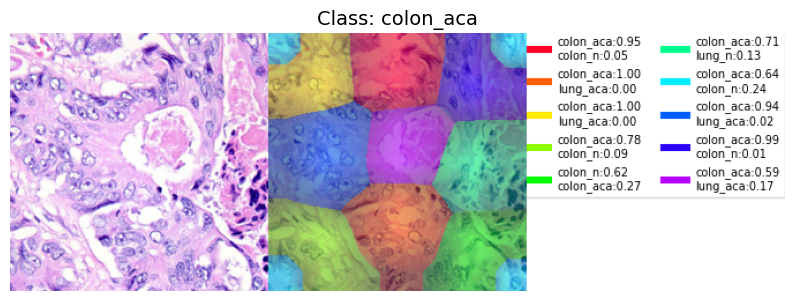

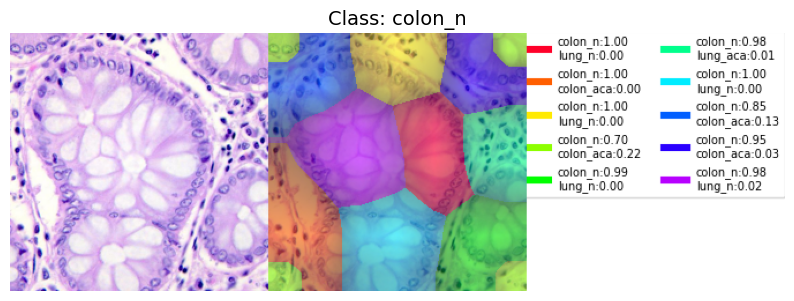

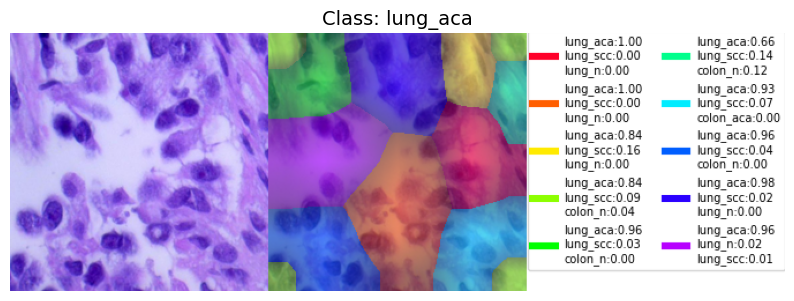

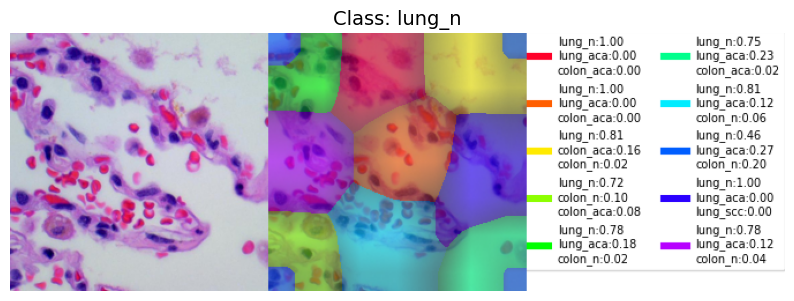

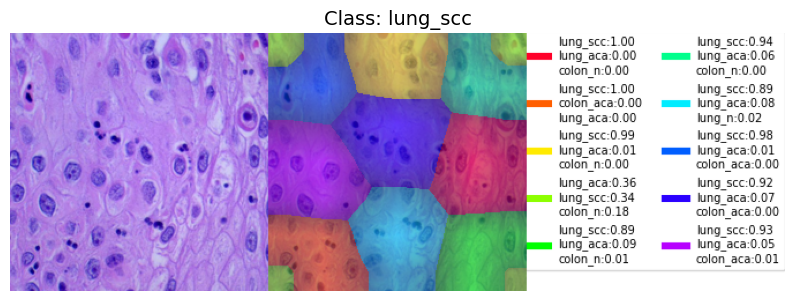

In [60]:
for class_name in classes:
    ref_img, img_norm_resized, tensor_in, target_class, class_out_target = class_imgs[class_name]

    if 'colon' in class_name:
        top_k = 2
    elif 'lung' in class_name:
        top_k = 3

    visualization, concept_label_strings = visualize_image(model, ref_img, img_norm_resized, tensor_in, n_components=10, top_k=top_k)
    plt.figure(figsize=(10, 10))
    plt.title(f"Class: {class_name}", fontsize=14)
    plt.axis('off')
    plt.imshow(visualization)